In [ ]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda, RunnableSequence, RunnablePassthrough
from langchain.graphs.graph_document import GraphDocument, Node, Relationship
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import json_repair

Main question

In [ ]:
# Initialize LLM (in this case llama3.1)
llm = OllamaLLM(model='llama3')

# Demo query
question = 'Show me how Lincoln and Reagan are connected?'

Ask LLM if graph is needed based on question

In [282]:
# LLM instructions
graph_needed_system = "Instruction: You have to decide whether or not the user is asking for a graph or vizualization based on a question. You can only answer with exactly yes or no."
graph_needed_human = "The user question is the following: '{question}'"

# Build chain for determining whether or not user needs graph
def build_graph_ask_chain():

    graph_needed_thread = [
        ('system', graph_needed_system),
        ('human', graph_needed_human)
    ]
    graph_needed_prompt = ChatPromptTemplate.from_messages(graph_needed_thread)
    graph_needed_llm_chain = graph_needed_prompt | llm
    return {"question": RunnablePassthrough()} | graph_needed_llm_chain

# Initialize and invoke chain
graph_needed = build_graph_ask_chain()
graph_needed.invoke(question)

'Yes'

Make graph based on document

In [283]:
# Load docs (HANDLED IN RAGMEUP)
def load_docs(dir):
    docs = []
    for f in os.listdir(f'{dir}'):
        if f.split('.')[1] == 'json':
            with open(f'{dir}/{f}', 'r') as file:
                docs.append(json.load(file))
    return docs

# Simulate context formatting of RAGMeUP (HANDLED IN RAGMEUP)
def format_context(docs):
    return '<NEWDOC>'.join([doc['text'] for doc in docs])

# Build GraphTransformer model
graph_transformer = LLMGraphTransformer(llm=llm)

# Load docs and format to format used in 'context' in RagMeUp
docs = load_docs('docs')
context = format_context(docs)

In [284]:
# Convert context into Document format and convert to graph
def build_graph_on_docs(context):
    documents = [Document(page_content=context)]
    return graph_transformer.convert_to_graph_documents(documents)

# Check if user asked for graph based on question and build it if LLM determines he did
graph_needed_answer = True if graph_needed.invoke(question) == 'Yes' else False
if graph_needed_answer:
    nw = build_graph_on_docs(context)

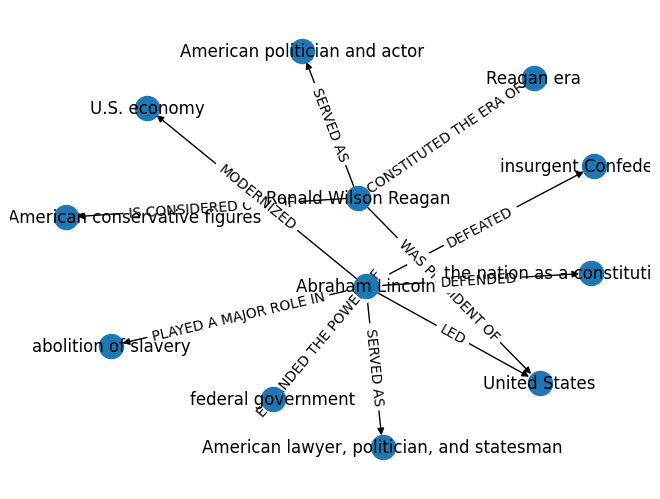

In [ ]:
# Build NetworkX graph from output of GraphTransformer
def build_nx_graph(network):
    graph = NetworkxEntityGraph()

    # Add nodes to the graph
    for node in network[0].nodes:
        graph.add_node(node.id)

    # Add edges to the graph
    for edge in network[0].relationships:
        graph._graph.add_edge(
                edge.source.id,
                edge.target.id,
                relation=edge.type,
        )
    return graph

# Draw network with labels
def draw_network(G):
    G = graph._graph

    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
    nx.draw(G, pos, with_labels=True)
    edge_labels = dict([((n1, n2), d['relation']) for n1, n2, d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

graph = build_nx_graph(nw)
draw_network(graph)

Relationship normalization

In [286]:
nw_description = str(nw)

In [ ]:
# LLM instructions
graph_normalizer_system = """
You are a knowledge graph design assistant. Your task is to clean up a knowledge graph based on nodes and relationships.
You are fed with nodes, these nodes may not have exactly the same name but have the same meaning. You are also fed with relationships, these relationships may not have exactly the same name but have the same meaning.
If you find similar nodes or relationships standardize the type of it. Additionally make the relationship types more concise keeping in source and target nodes in mind.
Only answer with the normalized graph in JSON format and no further description. Make a nodes object which contains a list of nodes and a relationships object that contains the list of relationships.
"""

graph_normalizer_human = "The network graph is described as: '{network}'"

# Build chain to normalize graph using LLM.
def build_normalize_graph_chain():
    normalize_graph_thread = [
        ('system', graph_normalizer_system),
        ('human', graph_normalizer_human)
    ]
    normalize_graph_prompt = ChatPromptTemplate.from_messages(normalize_graph_thread)
    normalize_graph_llm_chain = normalize_graph_prompt | llm
    return {"network": RunnablePassthrough()} | normalize_graph_llm_chain

# Initialize and invoke chain
graph_normalized = build_normalize_graph_chain()
nw_json = graph_normalized.invoke(nw_description)

In [288]:
nw_json

'{\n"nodes": [\n{"id": "U.S. economy", "type": "Economy"},\n{"id": "most prominent American conservative figures", "type": "Concept"},\n{"id": "Ronald Wilson Reagan", "type": "Person"},\n{"id": "the nation as a constitutional union", "type": "Concept"},\n{"id": "American politician and actor", "type": "Occupation"},\n{"id": "federal government", "type": "Organization"},\n{"id": "Abraham Lincoln", "type": "Person"},\n{"id": "United States", "type": "Country"},\n{"id": "Reagan era", "type": "Concept"}\n],\n"relationships": [\n{\n"source": {"id": "Abraham Lincoln", "type": "Person"},\n"target": {"id": "United States", "type": "Country"},\n"type": "WAS PRESIDENT OF"\n},\n{\n"source": {"id": "Abraham Lincoln", "type": "Person"},\n"target": {"id": "American lawyer, politician, and statesman", "type": "Occupation"},\n"type": "SERVED AS"\n},\n{\n"source": {"id": "Abraham Lincoln", "type": "Person"},\n"target": {"id": "United States", "type": "Country"},\n"type": "LED"\n},\n{\n"source": {"id": 

In [ ]:
# Build GraphDocument based on LLM output
def build_graph_document_from_llm(llm_out, context):
    graph_json = json_repair.loads(llm_out)
    nodes = [Node(id=node['id'], type=node['type']) for node in graph_json['nodes']]
    relationships = [Relationship(source=relationship['source'], target=relationship['target'], type=relationship['type']) for relationship in graph_json['relationships']]
    src_doc = Document(page_content=context)
    graph_doc = GraphDocument(nodes=nodes, relationships=relationships, source=src_doc)
    return graph_doc  

norm_graph_doc = build_graph_document_from_llm(nw_json, context)

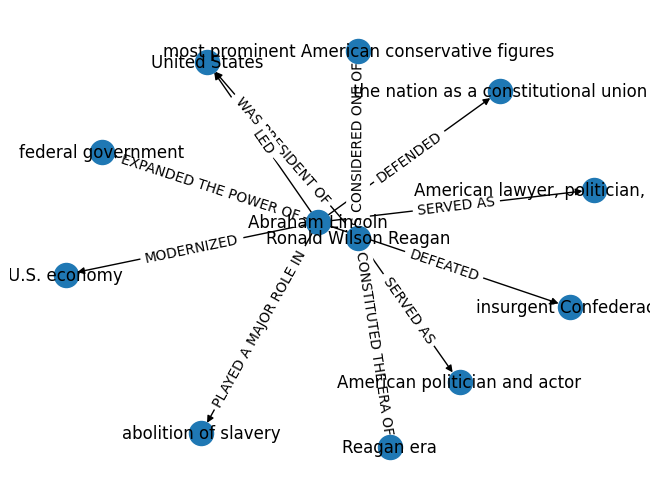

In [290]:
norm_graph = build_nx_graph([norm_graph_doc])
draw_network(norm_graph)

Graph comparison

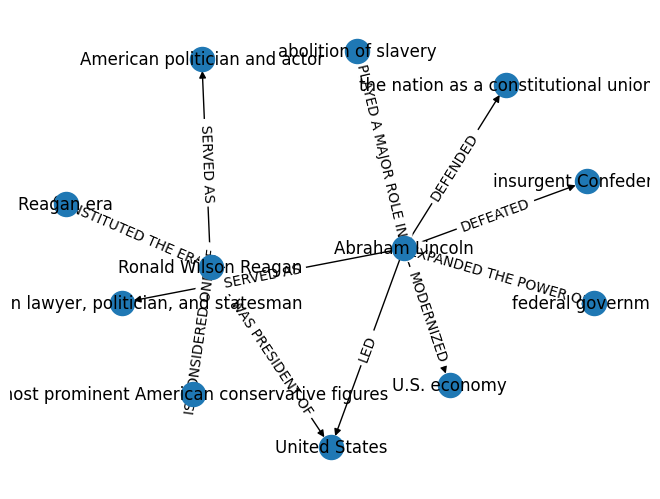

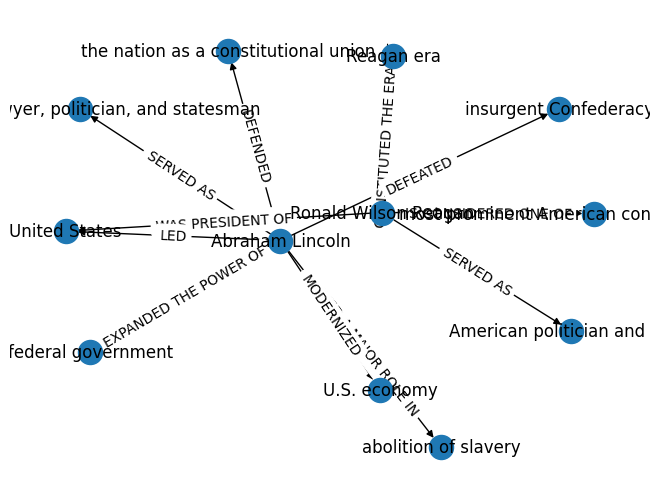

In [291]:
draw_network(graph)
draw_network(norm_graph)

PROMPTS TO ADD TO .ENV

In [ ]:
# Check if user needs graph
graph_needed_system = "Instruction: You have to decide whether or not the user is asking for a graph or vizualization based on a question. You can only answer with exactly yes or no."
graph_needed_human = "The user question is the following: '{question}'"

# Nodes and relationship normalization
graph_normalizer_system = """
You are a knowledge graph design assistant. Your task is to clean up a knowledge graph based on nodes and relationships.
You are fed with nodes, these nodes may not have exactly the same name but have the same meaning. You are also fed with relationships, these relationships may not have exactly the same name but have the same meaning.
If you find similar nodes or relationships standardize the type of it. Additionally make the relationship types more concise keeping in source and target nodes in mind.
Only answer with the normalized graph in JSON format and no further description. Make a nodes object which contains a list of nodes and a relationships object that contains the list of relationships.
"""
graph_normalizer_human = "The network graph is described as: '{network}'"

CLASS

In [ ]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda, RunnableSequence, RunnablePassthrough
from langchain.graphs.graph_document import GraphDocument, Node, Relationship

class GraphRAG:

    def __init__(self, llm, logger):
        self.logger = logger

        """Initialize the GraphRAG instance with required models and configurations."""
        self.llm = llm
        self.graph_transformer = self.initialize_graph_transformer()
        self.graph_ask_chain = self.initialize_need_graph_ask_chain()

    # Initialize LLMGraphTransformer
    def initialize_graph_transformer(self):
        return LLMGraphTransformer(llm=self.llm)

    # Build chain for determining whether or not user needs graph
    def initialize_need_graph_ask_chain(self):
        self.logger.info('CREATED GRAPH ASK CHAIN')
        """Create the chain to ask if user is requesting a graph"""
        graph_needed_thread = [
            ('system', os.getenv('needs_graph_ask_instruction')),
            ('human', os.getenv('needs_graph_ask_question'))
        ]
        graph_needed_prompt = ChatPromptTemplate.from_messages(graph_needed_thread)
        graph_needed_llm_chain = graph_needed_prompt | self.llm
        return {"question": RunnablePassthrough()} | graph_needed_llm_chain
    
    # Build chain to normalize graph using LLM.
    def build_normalize_graph_chain():
        normalize_graph_thread = [
            ('system', graph_normalizer_system),
            ('human', graph_normalizer_human)
        ]
        normalize_graph_prompt = ChatPromptTemplate.from_messages(normalize_graph_thread)
        normalize_graph_llm_chain = normalize_graph_prompt | llm
        return {"network": RunnablePassthrough()} | normalize_graph_llm_chain

    # Check if user needs graph based on question
    def needs_graph(self, user_query):
        response = self.graph_ask_chain.invoke(user_query)
        return True if response == 'yes' else False
    
    # Build graph from context
    def build_graph_on_docs(self, context):
        documents = [Document(page_content=context)]
        return self.graph_transformer.convert_to_graph_documents(documents)
    
    # Build GraphDocument based on LLM JSON output
    def build_graph_document_from_llm(llm_out, context):
        graph_json = json_repair.loads(llm_out)
        nodes = [Node(id=node['id'], type=node['type']) for node in graph_json['nodes']]
        relationships = [Relationship(source=relationship['source'], target=relationship['target'], type=relationship['type']) for relationship in graph_json['relationships']]
        src_doc = Document(page_content=context)
        graph_doc = GraphDocument(nodes=nodes, relationships=relationships, source=src_doc)
        return graph_doc 


HELPER FUNCTIONS

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Build NetworkX graph from output of GraphTransformer
def build_nx_graph(network):
    graph = NetworkxEntityGraph()

    # Add nodes to the graph
    for node in network[0].nodes:
        graph.add_node(node.id)

    # Add edges to the graph
    for edge in network[0].relationships:
        graph._graph.add_edge(
                edge.source.id,
                edge.target.id,
                relation=edge.type,
        )
    return graph

# Draw network with labels
def draw_network(G):
    G = graph._graph

    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
    nx.draw(G, pos, with_labels=True)
    edge_labels = dict([((n1, n2), d['relation']) for n1, n2, d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()